<a href="https://colab.research.google.com/github/Leomutz/NIDS1/blob/main/2024_22october_nsl_kdd_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Flatten
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

In [ ]:
# load the dataset
df_train = pd.read_csv('/content/NIDS_datasets/KDDTrain+.txt', header=None)
df_test = pd.read_csv('/content/NIDS_datasets/KDDTest+.txt', header=None)

In [ ]:
# check the shape of the dataset
print(df_train.shape, df_test.shape)

(125973, 43) (22544, 43)


In [ ]:
# merging the dataset
df = pd.concat([df_train, df_test])

# check the shape
print(df.shape)

(148517, 43)


In [ ]:
# add columns in the dataset
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_byte','land','wrong_fragment',
                    'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
                    'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_logins',
                    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
                    'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
            'dst_host_same_srv_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
        'dst_host_rerror_rate','dst_host_srv_rerror_rate','class','difficulty_level']


In [ ]:
# check the column names by accessing the dataframe
print(df.head())

   duration protocol_type   service flag  src_bytes  dst_byte  land  \
0         0           tcp  ftp_data   SF        491         0     0   
1         0           udp     other   SF        146         0     0   
2         0           tcp   private   S0          0         0     0   
3         0           tcp      http   SF        232      8153     0   
4         0           tcp      http   SF        199       420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_srv_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2                   

In [ ]:
# identify the missing values
df.isnull().values.any()

False

In [ ]:
# select categorical variables
df_cat = df.select_dtypes('object')
df_cat.head()

,protocol_type,service,flag,class
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal


In [ ]:
# list of categorical columns without the label
cols_list = ['protocol_type', 'service', 'flag']
cols_list

['protocol_type', 'service', 'flag']

In [ ]:
# one-hot encoding function
def one_hot_encode(data, col):
  for i in col:
    dummies = pd.get_dummies(data[i], prefix=i, drop_first=False, dtype='int')
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(columns=[i])
  return data

In [ ]:
#perform one hot encoding
df_onehot = one_hot_encode(df, cols_list)
print(df_onehot.shape)

(148517, 124)


In [ ]:
df_onehot['class']

,class
0,normal
1,normal
2,neptune
3,normal
4,normal
...,...
22539,normal
22540,normal
22541,back
22542,normal


In [ ]:
#copy data from the original
df_data = df_onehot.copy()
df_data.shape

(148517, 124)

In [ ]:
#fixing labels on the column 'class'

classlist = []
attack1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
attack2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
attack3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
attack4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

# initialize the count of each attack category
DoS = 0
Probe = 0
U2R = 0
R2L = 0
Normal = 0

for i in df_data['class']:
  if i in attack1:
    classlist.append('DoS')
    DoS += 1
  elif i in attack2:
    classlist.append('Probe')
    Probe += 1
  elif i in attack3:
    classlist.append('U2R')
    U2R += 1
  elif i in attack4:
    classlist.append('R2L')
    R2L += 1
  else:
    classlist.append('Normal')
    Normal += 1

print('Number of attacks in groups:\n')
print('DoS:{}, Probe:{}, U2R:{}, R2L:{}, Normal:{}'.format(DoS, Probe, U2R, R2L, Normal))

Number of attacks in groups:

DoS:53387, Probe:14077, U2R:119, R2L:3702, Normal:77232


In [ ]:
#view the class list
classlist[:10]

['Normal',
 'Normal',
 'DoS',
 'Normal',
 'Normal',
 'DoS',
 'DoS',
 'DoS',
 'DoS',
 'DoS']

In [ ]:
# now append the class column to the dataFrame
df_data['class'] = classlist
df_data.head()

,duration,src_bytes,dst_byte,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#verify categorical variables
#only the label class
df_data.select_dtypes('object').head()

,class
0,Normal
1,Normal
2,DoS
3,Normal
4,Normal


In [ ]:
#separate labels from the dataset
y = df_data.pop('class')

# the remaining data will be X
X = df_data
print(X.shape, y.shape)

(148517, 123) (148517,)


In [ ]:
# encoding labels function

# binary classification (0 for normal and 1 for attack)
def attack_encode_bin(attack):
  if attack == 'Normal':
    return 0
  else:
    return 1

# multi-class classification
# multi-labels (0,1,2,3,4)
def attack_encode_mult(attack):
  if attack == 'Normal':
    return 0
  elif attack == 'DoS':
    return 1
  elif attack == 'Probe':
    return 2
  elif attack == 'U2R':
    return 3
  else:
    return 4

In [ ]:
# binary classification labels
y_bin = y.apply(attack_encode_bin)
print(y_bin.unique())

[0 1]


In [ ]:
# multi-class classification labels
y_mult = y.apply(attack_encode_mult)
print(y_mult.unique())

[0 1 4 2 3]


In [ ]:
# binarize labels for multi-class
y_mult = LabelBinarizer().fit_transform(y_mult)
print(y_mult[:3])

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]]


In [ ]:
# binary classification
X_train,X_test, y_train,y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(118813, 123) (29704, 123)
(118813,) (29704,)


In [ ]:
# preprocessing training dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# normalize (scaling) the test data by using the training mean and std
X_test_scaled = scaler.transform(X_test)

In [ ]:
# binary class classification
model_bin = Sequential()
model_bin.add(Conv1D(64,3,padding='same', input_shape=(123,1),activation='relu'))
model_bin.add(MaxPool1D(pool_size=(4)))
#model_bin.add(Dropout(0.2))

model_bin.add(Conv1D(32,3,padding='same',activation='relu'))
model_bin.add(MaxPool1D(pool_size=(4)))
model_bin.add(Dropout(0.2))

#model_bin.add(Conv1D(32,3,padding='same',activation='relu'))
#model_bin.add(MaxPool1D(pool_size=(4)))
#model_bin.add(Dropout(0.2))

model_bin.add(Flatten())
model_bin.add(Dense(units=50))
model_bin.add(Dense(units=1, activation='sigmoid'))

optimizer_bin = keras.optimizers.Adam(learning_rate=0.0001)
model_bin.compile(loss='binary_crossentropy', optimizer=optimizer_bin,
                  metrics=['accuracy'])

model_bin.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 123, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 30, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 50)                  │          11,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,733 (69.27 KB)

 Trainable params: 17,733 (69.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model
history = model_bin.fit(X_train_scaled, y_train, epochs=100,
                        batch_size=5000, validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9457 - loss: 0.1379 - val_accuracy: 0.9522 - val_loss: 0.1230
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9465 - loss: 0.1363 - val_accuracy: 0.9519 - val_loss: 0.1216
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9486 - loss: 0.1324 - val_accuracy: 0.9536 - val_loss: 0.1197
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9473 - loss: 0.1321 - val_accuracy: 0.9535 - val_loss: 0.1183
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9501 - loss: 0.1290 - val_accuracy: 0.9554 - val_loss: 0.1162
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9485 - loss: 0.1300 - val_accuracy: 0.9546 - val_loss: 0.1151
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9509 - loss: 0.1260 - val_accuracy: 0.9564 - val_loss: 0.1134
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9495 - loss: 0.1260 - val_accuracy: 0.

In [ ]:
# predicting target on the test data
test_pred = model_bin.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test prediction\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9795 - loss: 0.0598
Test prediction
 Loss: 0.05909160152077675
 Accuracy: 98.00699949264526%


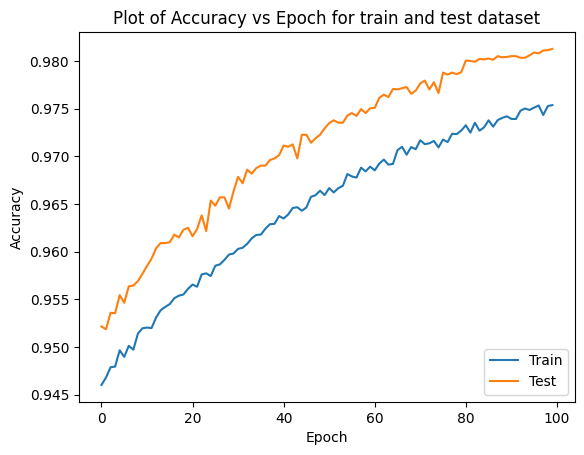

In [ ]:
# plot of accuracy vs epoch for train and test dataset

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Plot of Accuracy vs Epoch for train and test dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('/content/Plots/plot_accuracy_epoch_binary.eps')
plt.show()

In [ ]:
# predict on the test dataset
y_pred = model_bin.predict(X_test_scaled, batch_size=500)

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


In [ ]:
# view the classification report on the test dataset
class_names = ['Normal', 'Attack']
y_pred = np.round(y_pred)
print('Classification Report on Test data\n',
      classification_report(y_test, y_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.99      0.98      0.98     15486
      Attack       0.97      0.99      0.98     14218

    accuracy                           0.98     29704
   macro avg       0.98      0.98      0.98     29704
weighted avg       0.98      0.98      0.98     29704



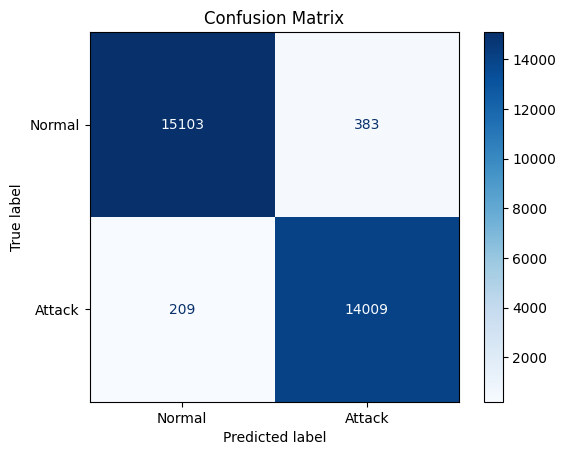

In [ ]:
# view the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('/content/Plots/confusion_matrix_binary.eps')
plt.show()

In [ ]:
# multi-class classification
X_train,X_test, y_train,y_test = train_test_split(X, y_mult, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(118813, 123) (29704, 123)
(118813, 5) (29704, 5)


In [ ]:
# preprocessing training dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# normalize (scaling) the test set only
X_test_scaled = scaler.transform(X_test)

In [ ]:
# multi-class classification

model_mult = Sequential()
model_mult.add(Conv1D(64,3,padding='same',activation='relu', input_shape=(123,1)))
model_mult.add(MaxPool1D(pool_size=(4)))
#model_mult.add(BatchNormalization())
model_mult.add(Dropout(0.2))

model_mult.add(Conv1D(32,3,padding='same',activation='relu'))
model_mult.add(MaxPool1D(pool_size=(4)))
#model_mult.add(Dropout(0.2))

#model_mult.add(Conv1D(32,3,padding='same',activation='relu'))
#model_mult.add(MaxPool1D(pool_size=(4)))
#model_mult.add(Dropout(0.2))

model_mult.add(Flatten())
model_mult.add(Dense(units=50))
model_mult.add(Dense(units=5, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_mult.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])

model_mult.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 123, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 30, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 50)                  │          11,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model
history = model_mult.fit(X_train_scaled, y_train, epochs=100, batch_size=5000,
                         validation_split=0.2)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.1979 - loss: 1.5836 - val_accuracy: 0.6175 - val_loss: 1.5011
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6075 - loss: 1.4574 - val_accuracy: 0.6372 - val_loss: 1.3775
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6311 - loss: 1.3271 - val_accuracy: 0.6329 - val_loss: 1.2400
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6248 - loss: 1.1883 - val_accuracy: 0.6307 - val_loss: 1.1018
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6285 - loss: 1.0606 - val_accuracy: 0.6300 - val_loss: 0.9916
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6324 - loss: 0.9660 - val_accuracy: 0.6457 - val_loss: 0.9138
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6470 - loss: 0.8960 - val_accuracy: 0.6834 - val_loss: 0.8572
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6853 - loss: 0.8504 - val_accuracy: 0

In [ ]:
# predicting target on test data
test_pred = model_mult.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test results\n Loss: {test_pred[0]}\n Accuracy: {test_pred[1]*100}%')

929/929 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9546 - loss: 0.1199
Test results
 Loss: 0.12017875164747238
 Accuracy: 95.6234872341156%


In [ ]:
# on test dataset
y_pred = model_mult.predict(X_test_scaled, batch_size=500)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
# print the classification report on the test data

class_names = ['Normal', 'DoS','Probe','U2R','R2L']
#y_rounded_pred = np.round(y_pred) # or using np.argmax()
#y_pred_labels = [np.argmax(i) for i in y_pred]
#y_pred_labels[:5]

y_rounded_pred = np.round(y_pred)
print("Classification Report on Test data\n",
     classification_report(y_test, y_rounded_pred, target_names=class_names))

Classification Report on Test data
               precision    recall  f1-score   support

      Normal       0.96      0.97      0.97     15486
         DoS       0.98      0.96      0.97     10688
       Probe       0.93      0.90      0.92      2749
         U2R       0.00      0.00      0.00        25
         R2L       0.91      0.59      0.71       756

   micro avg       0.97      0.95      0.96     29704
   macro avg       0.76      0.68      0.71     29704
weighted avg       0.96      0.95      0.95     29704
 samples avg       0.95      0.95      0.95     29704



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


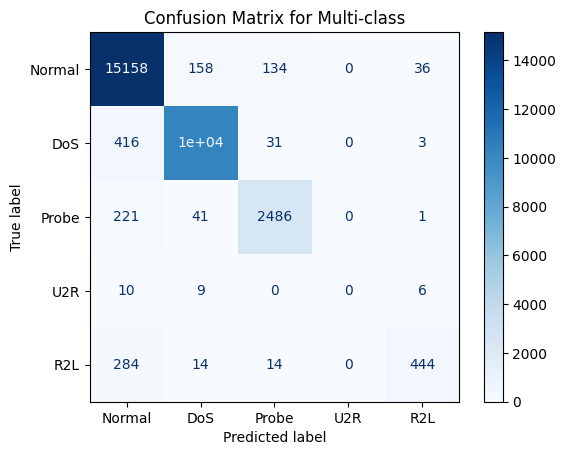

In [ ]:
# view the confusion matrix for multi-class classification
cm = confusion_matrix(y_test.argmax(axis=1), y_rounded_pred.argmax(axis=1))

cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_fig.plot(cmap=plt.cm.Blues,)
#ConfusionMatrixDisplay.from_estimator(model_mult, y_test.argmax(axis=1), y_rounded_pred.argmax(axis=1),values_format='d', cmap='Blues')
plt.title('Confusion Matrix for Multi-class')

plt.savefig('/content/Plots/confusion_matrix_multi-class.eps')
plt.show()
